Preprocessing cleans the SVI data for percentage estimates (collected in the census), by removing missing data, removing unnecessary variables and finally, normalizing the data. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import the SVI data for Maryland and filter by Baltimore City county
df = pd.read_csv("../raw_data/svi_md.csv")
df = df.loc[df['STCNTY'] == 24510] 
df = df.replace(-999, np.nan)

df.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
9,24,MARYLAND,MD,24510,Baltimore City,24510100300,"Census Tract 1003, Baltimore city, Maryland",0.060351,3676,443,...,0.0,NaN,1.0,NaN,NaN,0,12,NaN,NaN,4148
10,24,MARYLAND,MD,24510,Baltimore City,24510250600,"Census Tract 2506, Baltimore city, Maryland",2.190689,0,12,...,NaN,NaN,NaN,NaN,NaN,0,12,NaN,NaN,3864
15,24,MARYLAND,MD,24510,Baltimore City,24510010300,"Census Tract 103, Baltimore city, Maryland",0.260188,2571,237,...,0.0,0.0,0.0,0.0,0.0,52,67,2.0,2.6,1095
22,24,MARYLAND,MD,24510,Baltimore City,24510240400,"Census Tract 2404, Baltimore city, Maryland",0.465254,2669,255,...,0.0,0.0,0.0,0.0,0.0,131,101,5.0,3.8,2764
28,24,MARYLAND,MD,24510,Baltimore City,24510261100,"Census Tract 2611, Baltimore city, Maryland",0.084858,1792,161,...,0.0,0.0,0.0,0.0,0.0,60,51,3.4,2.7,899


In [3]:
# Extract only the percentage estimate columns
ep_df = df.loc[:, df.columns.str.contains('FIPS|E_.*POP|EP_.*')]
ep_df.head()                   

,FIPS,E_TOTPOP,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_MINRTY,EP_LIMENG,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ,EP_UNINSUR,E_DAYPOP
9,24510100300,3676,NaN,NaN,10807.0,39.4,0.5,0.0,NaN,0.0,85.2,1.2,0.0,NaN,0.0,NaN,100.0,NaN,4148
10,24510250600,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3864
15,24510010300,2571,4.3,1.1,68345.0,4.5,4.7,9.8,4.4,1.8,14.9,0.9,0.7,0.0,0.6,5.5,0.0,2.0,1095
22,24510240400,2669,2.1,2.2,51469.0,10.8,7.6,11.5,3.6,1.9,6.1,0.0,13.8,0.0,0.5,4.0,0.0,5.0,2764
28,24510261100,1792,7.7,5.3,63780.0,4.8,5.6,9.7,8.5,1.4,14.7,0.0,0.0,0.0,0.5,8.4,0.0,3.4,899


In [4]:
# Remove rows for 2 census tracts with missing data
drop_fips = [
             24510250600,  # South harbor
             24510100300   # Prison
             ]
drop_indices = ep_df.index[ep_df["FIPS"].isin(drop_fips)]
ep_df = ep_df.drop(index=drop_indices)

ep_df.head()

,FIPS,E_TOTPOP,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_MINRTY,EP_LIMENG,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ,EP_UNINSUR,E_DAYPOP
15,24510010300,2571,4.3,1.1,68345.0,4.5,4.7,9.8,4.4,1.8,14.9,0.9,0.7,0.0,0.6,5.5,0.0,2.0,1095
22,24510240400,2669,2.1,2.2,51469.0,10.8,7.6,11.5,3.6,1.9,6.1,0.0,13.8,0.0,0.5,4.0,0.0,5.0,2764
28,24510261100,1792,7.7,5.3,63780.0,4.8,5.6,9.7,8.5,1.4,14.7,0.0,0.0,0.0,0.5,8.4,0.0,3.4,899
29,24510271102,4505,2.9,3.3,32299.0,0.0,5.8,5.8,2.5,1.1,39.1,0.3,0.0,0.0,0.0,1.4,74.3,3.3,4468
37,24510010200,2869,5.9,1.4,56058.0,4.5,8.0,11.9,7.7,1.1,11.3,0.3,8.0,0.0,0.7,7.8,0.0,2.5,1642


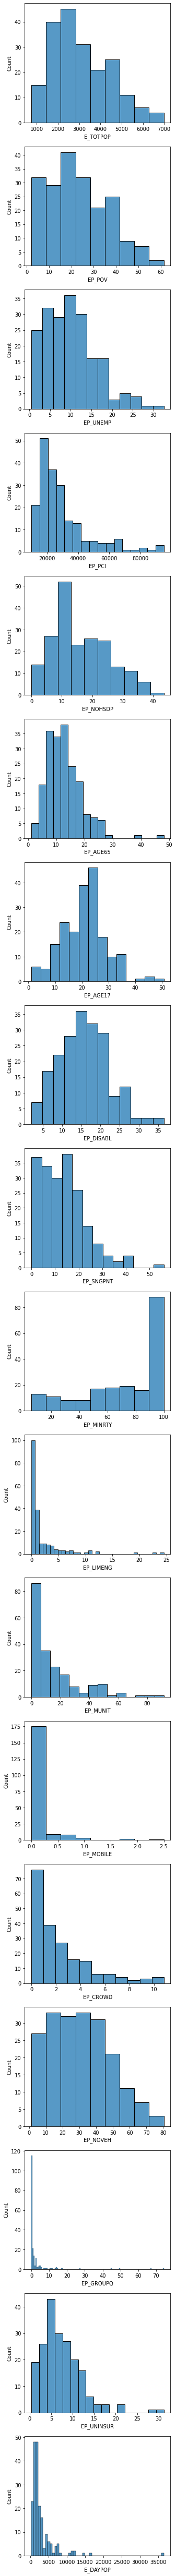

In [5]:
# Plot the estimates of all SVI factors. Use histogram plots to easily visualize the distributions.  
def get_hists(cols, data):
    fig, axs = plt.subplots(len(cols), 1, figsize=(5, 5 * len(cols)))
    for ax, col in zip(axs, cols):
        sns.histplot(data=data, x=col, ax=ax)


cols = ep_df.columns[1:] # ignore the FIPS column
get_hists(cols, ep_df)

In [6]:
# Normalize the data using a Box-Cox power transformer
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method='box-cox')

df_temp = ep_df.drop(columns='FIPS')

scaled_df = pd.DataFrame(scaler.fit_transform(1 + df_temp), columns = df_temp.columns)

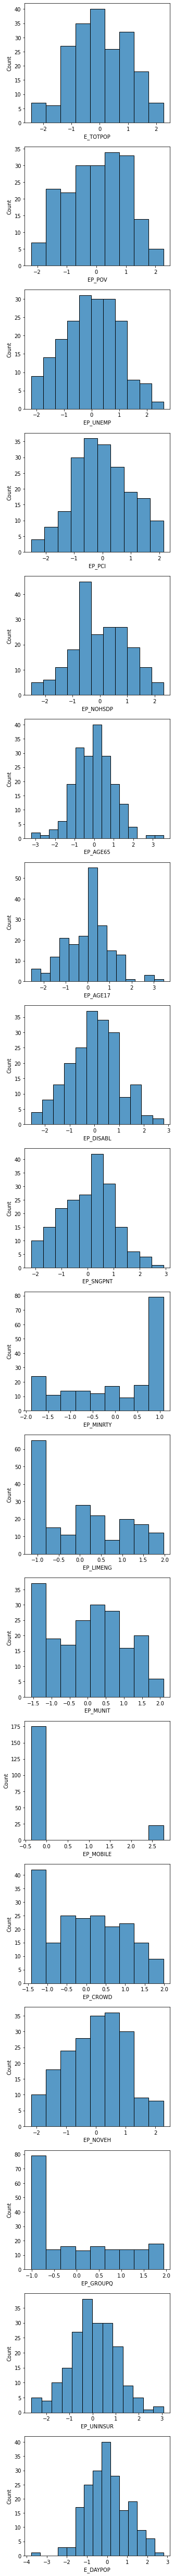

In [7]:
# Now plot the normalized estimates of all SVI factors
cols = scaled_df.columns
get_hists(cols, scaled_df)

<AxesSubplot:>

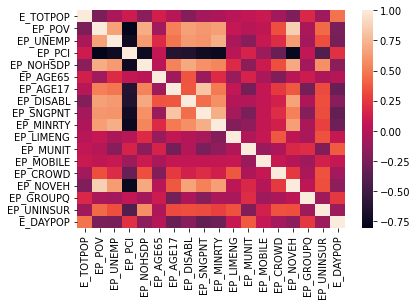

In [8]:
# Finally use correlation analysis to understand which variables are highly correlated. 
# Visualize the correlation matrix
corr_matrix = scaled_df.corr()
sns.heatmap(corr_matrix)

In [9]:
# Add back the FIPS columns in final processing
scaled_df['FIPS'] = list(ep_df['FIPS'])

In [10]:
scaled_df.to_csv("../processed_data/SVI_PT.csv", index=False)